In [206]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

In [207]:
# Cargar los archivos
features = pd.read_csv("../data/kaggle/elliptic_txs_features.csv", header=None)
edges = pd.read_csv("../data/kaggle/elliptic_txs_edgelist.csv")
classes = pd.read_csv("../data/kaggle/elliptic_txs_classes.csv")

# Renombrar columnas para claridad
features = features.rename(columns={0: "txId", 1: "time_step"})
edges = edges.rename(columns={"txId1": "source", "txId2": "target"})
classes = classes.rename(columns={"txId": "txId", "class": "label"})

# renombrar columnas de features 
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

In [208]:
# chequeamos
print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")



Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



In [209]:
# merge with classes
df_features = pd.merge(features, classes, left_on='txId', right_on='txId', how='left')
df_features['label'] = df_features['label'].apply(lambda x: '0' if x == "unknown" else x)
# chequeamos que las clases nos quedaron bien armadas
df_features.groupby('label').size()

label
0    157205
1      4545
2     42019
dtype: int64

## Visualización

In [210]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tema global
plt.style.use('seaborn-v0_8-whitegrid')


# Tema para presentación
plt.rcParams.update({
    # Tamaño general
    'figure.figsize': (10, 6),
    'figure.dpi': 150,

    # Fondo transparente
    'figure.facecolor': 'none',
    'axes.facecolor': 'none',

    # Título y ejes
    'axes.titlesize': 18,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',

    # Ejes y ticks
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.edgecolor': '#333333',
    'axes.linewidth': 1.2,

    # Leyenda
    'legend.fontsize': 12,
    'legend.frameon': False,

    # Líneas y colores
    'lines.linewidth': 2,
    'lines.markersize': 6,

})


### Etiquetas

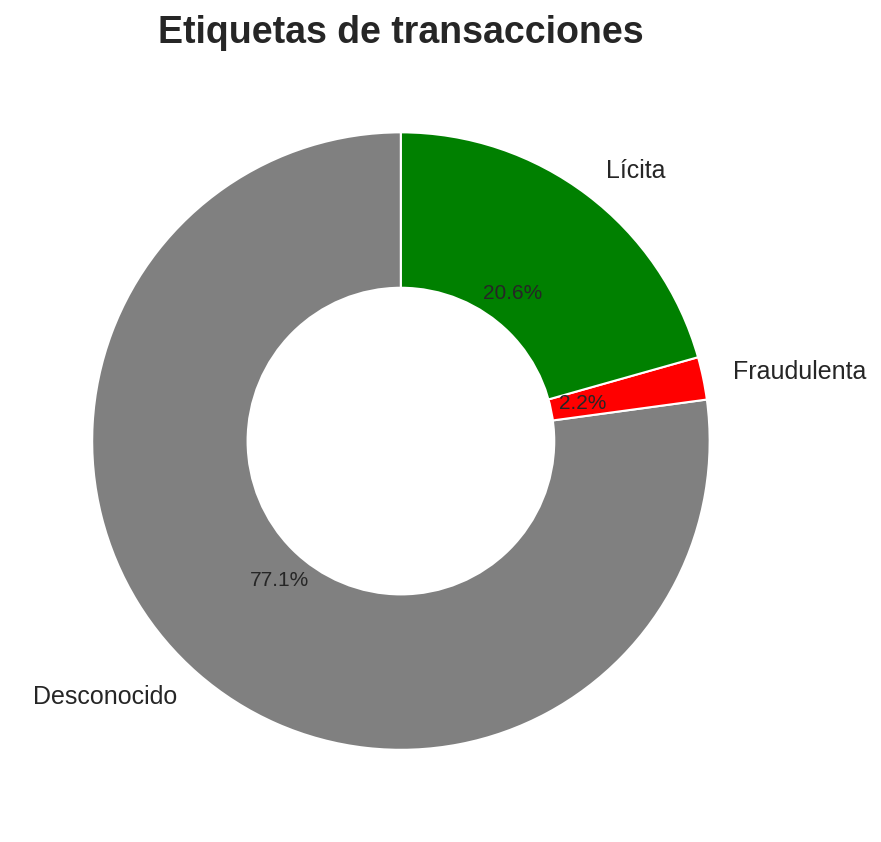

In [211]:
# Contar ocurrencias
fraud_counts = df_features['label'].value_counts().sort_index()

# Renombrar etiquetas para el gráfico
fraud_counts.index = fraud_counts.index.map({'2': 'Lícita', '1': 'Fraudulenta', '0': 'Desconocido'})

# Donut chart
colors = ['gray', 'red', 'green']  # No fraude, fraude, desconocido

plt.figure(figsize=(6, 6))
plt.pie(
    fraud_counts,
    labels=fraud_counts.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Círculo central para el efecto "donut"
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Etiquetas de transacciones")
plt.tight_layout()
plt.savefig("./figures/transactions-by-label.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()


In [212]:
df_features.columns

Index(['txId', 'time_step', 'tx_feat_2', 'tx_feat_3', 'tx_feat_4', 'tx_feat_5',
       'tx_feat_6', 'tx_feat_7', 'tx_feat_8', 'tx_feat_9',
       ...
       'agg_feat_64', 'agg_feat_65', 'agg_feat_66', 'agg_feat_67',
       'agg_feat_68', 'agg_feat_69', 'agg_feat_70', 'agg_feat_71',
       'agg_feat_72', 'label'],
      dtype='object', length=168)

### Etiquetas en función de time-step

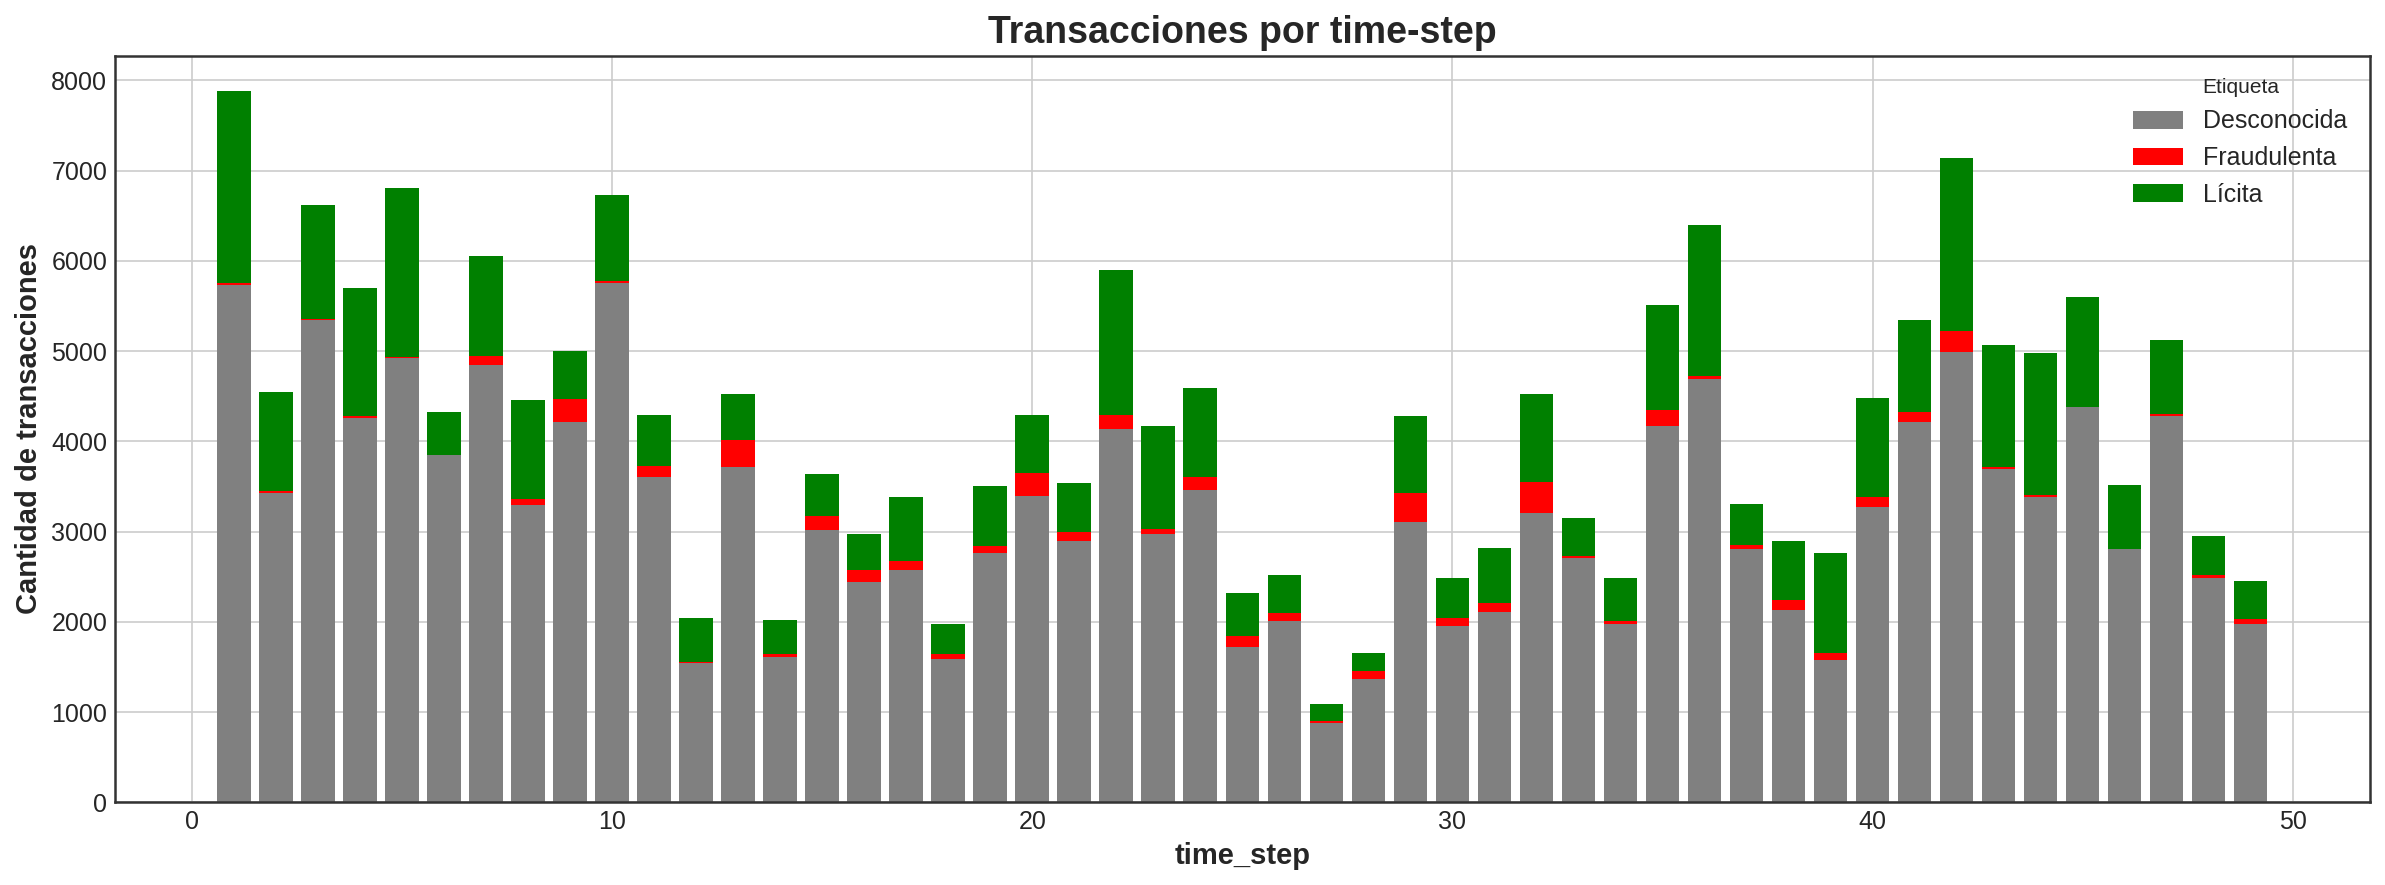

In [213]:
# Mapeo de colores
color_map = {
    '1': 'red',       # Fraudulenta
    '2': 'green',     # Lícita
    '0': 'gray'       # Desconocida
}

# Agrupar y pivotear para contar transacciones por time_step y label
count_label = (
    df_features
    .groupby(['time_step', 'label'])
    .size()
    .unstack(fill_value=0)
)

# Crear el gráfico apilado
fig, ax = plt.subplots(figsize=(16, 6))

# Acumulador para "bottom"
bottom = None
for etiqueta in count_label.columns:
    ax.bar(
        count_label.index,
        count_label[etiqueta],
        label={'1': 'Fraudulenta', '2': 'Lícita', '0': 'Desconocida'}[etiqueta],
        color=color_map[etiqueta],
        bottom=bottom
    )
    # Actualizar bottom para la siguiente serie
    bottom = count_label[etiqueta] if bottom is None else bottom + count_label[etiqueta]

ax.set_title('Transacciones por time-step')
ax.set_xlabel('time_step')
ax.set_ylabel('Cantidad de transacciones')
ax.legend(title="Etiqueta")
plt.tight_layout()
plt.savefig("./figures/transactions-by-timestep.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()


### Datos con etiquetas conocidas

In [214]:
# nos quedamos con datos etiquetados
data = df_features[(df_features['label']=='1') | (df_features['label']=='2')]
#data = df_features

In [215]:
data_ts1 = data[data['time_step'] == 29]
data.shape, data_ts1.shape

((46564, 168), (1174, 168))

In [216]:
# Filtrar edges para incluir solo los que conecten nodos del time-step 29
valid_nodes = set(data_ts1["txId"])
edges_ts1 = edges[
    edges["source"].isin(valid_nodes) &
    edges["target"].isin(valid_nodes)
]

# Crear el grafo dirigido
G_ts1 = nx.DiGraph()

# Agregar nodos con data_ts1
for _, row in data_ts1.iterrows():
    tx_id = row["txId"]
    feats = row[2:].values  
    G_ts1.add_node(tx_id, data_ts1=feats)

# Agregar aristas
for _, row in edges_ts1.iterrows():
    G_ts1.add_edge(row["source"], row["target"])

# Agregar etiquetas de clase a los nodos
label_dict = dict(zip(classes["txId"], classes["label"]))
nx.set_node_attributes(G_ts1, label_dict, "label")

print(f"Nodos: {G_ts1.number_of_nodes()}, Aristas: {G_ts1.number_of_edges()}")

Nodos: 1174, Aristas: 911


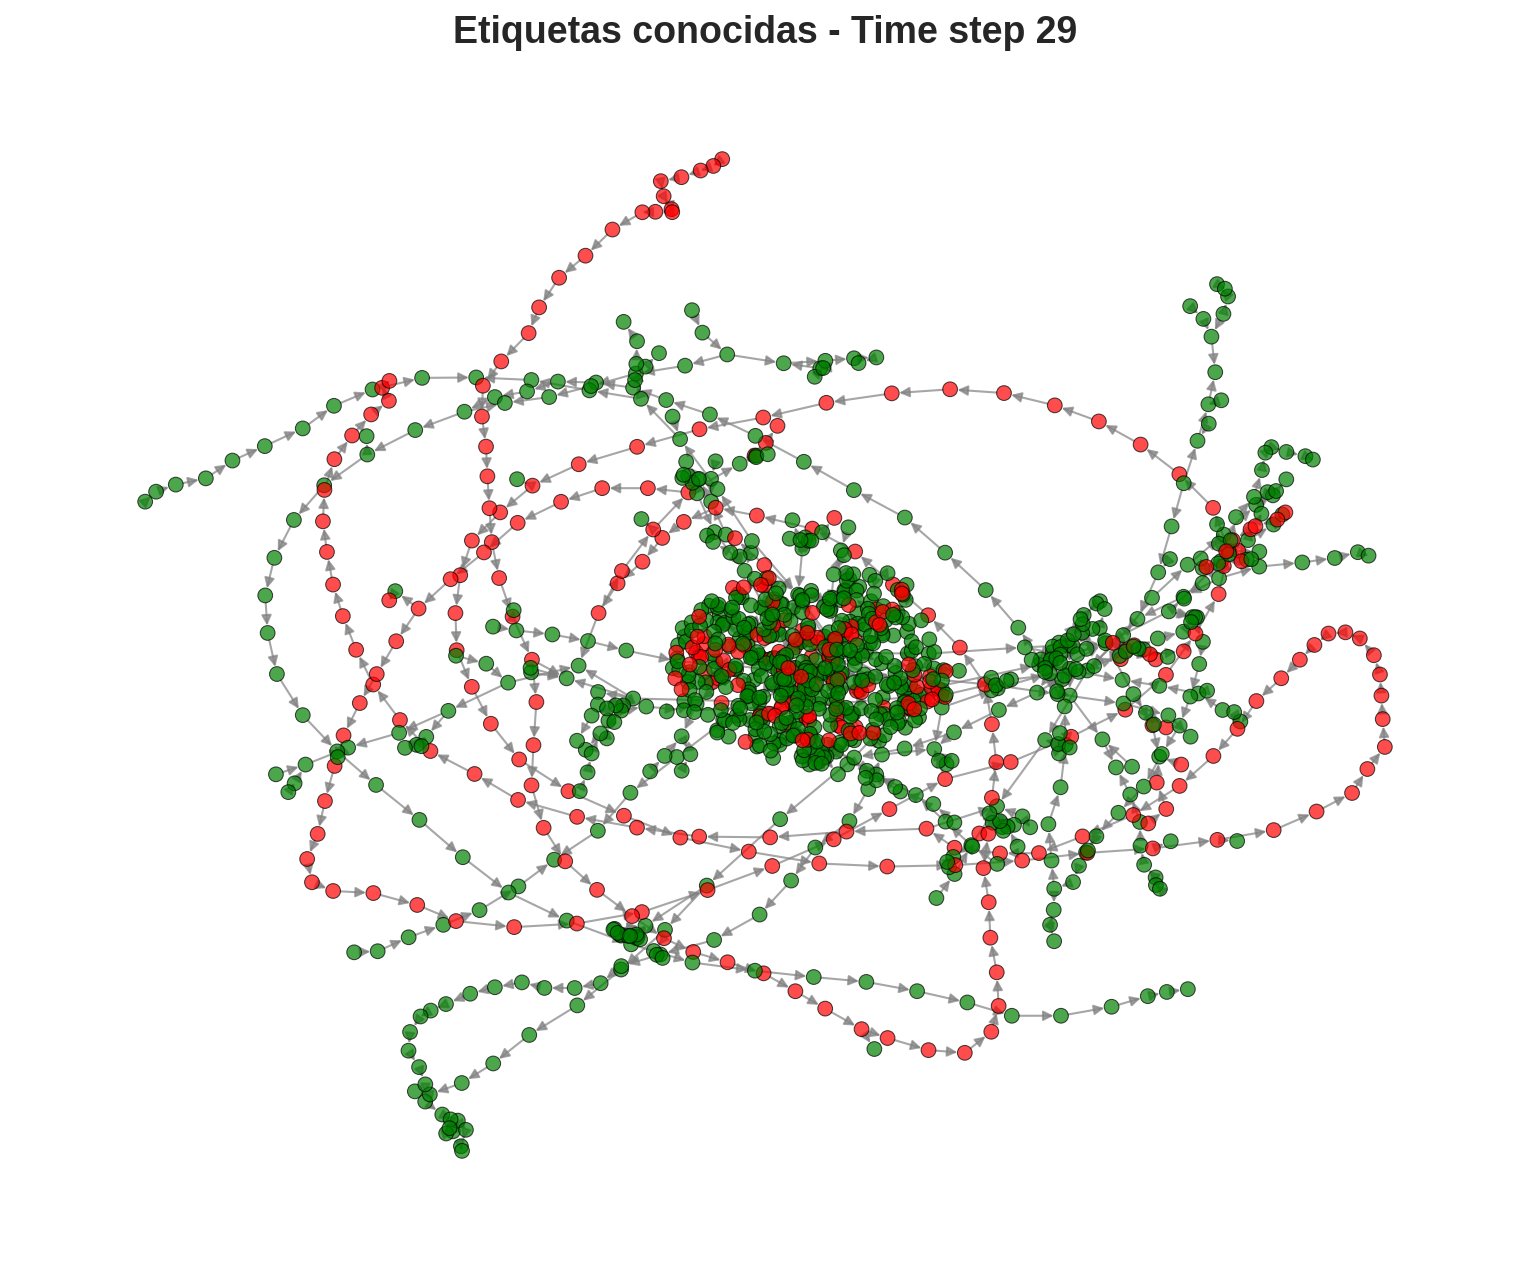

In [217]:
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_ts1, seed=43)  # layout para posiciones de nodos

# Colores por etiqueta
labels = nx.get_node_attributes(G_ts1, "label")
node_colors = [
    "red" if labels.get(node) == "1" 
    else "green" if labels.get(node) == "2" 
    else "grey"
    for node in G_ts1.nodes()
]

nx.draw(
    G_ts1,
    pos,
    with_labels=False,
    node_size=50,
    node_color=node_colors,
    edgecolors= 'black', 
    linewidths = 0.5,
    edge_color="gray",
    alpha=0.7
)

plt.title("Etiquetas conocidas - Time step 29")
plt.savefig("./figures/graph-labels-timestep29.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()


## Grafo completo

In [218]:
# Crear el grafo dirigido
G = nx.DiGraph()

# Agregar nodos con data
for _, row in data.iterrows():
    tx_id = row["txId"]
    feats = row[2:].values  
    G.add_node(tx_id, data=feats)

# Agregar aristas
for _, row in edges.iterrows():
    G.add_edge(row["source"], row["target"])

# Agregar etiquetas de clase a los nodos
label_dict = dict(zip(classes["txId"], classes["label"]))
nx.set_node_attributes(G, label_dict, "label")

print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")

Nodos: 203769, Aristas: 234355


### Grado promedio

### Por time step

In [219]:
# 1. Obtener los grados de cada nodo
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# 2. Crear un DataFrame con txId, time_step, in_degree y out_degree
df_degrees = data[['txId', 'time_step']].copy()
df_degrees['in_degree'] = df_degrees['txId'].map(in_degrees).fillna(0).astype(int)
df_degrees['out_degree'] = df_degrees['txId'].map(out_degrees).fillna(0).astype(int)

# 3. Agrupar por time_step y calcular promedio
grado_promedio_por_timestep = df_degrees.groupby('time_step')[['in_degree', 'out_degree']].mean()

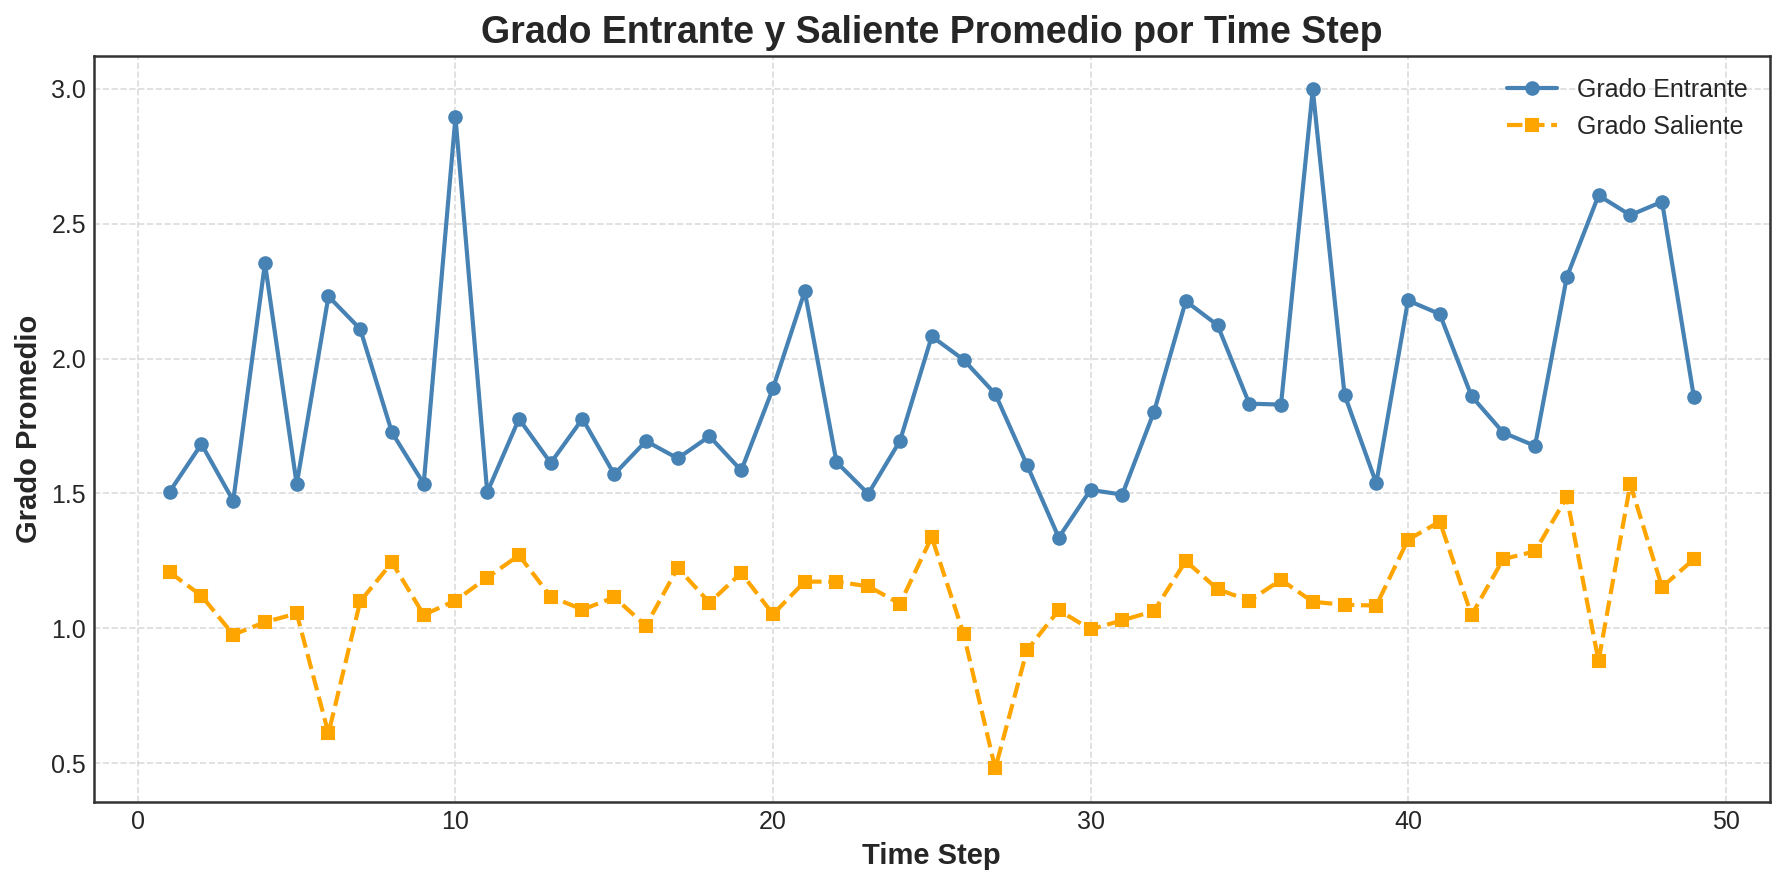

In [220]:

fig, ax = plt.subplots(figsize=(12, 6))

# Línea para grado entrante
ax.plot(
    grado_promedio_por_timestep.index,
    grado_promedio_por_timestep['in_degree'],
    marker='o',
    linestyle='-',
    color='steelblue',
    label='Grado Entrante'
)

# Línea para grado saliente
ax.plot(
    grado_promedio_por_timestep.index,
    grado_promedio_por_timestep['out_degree'],
    marker='s',
    linestyle='--',
    color='orange',
    label='Grado Saliente'
)

ax.set_xlabel('Time Step')
ax.set_ylabel('Grado Promedio')
ax.set_title('Grado Entrante y Saliente Promedio por Time Step')
ax.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Grado por etiqueta

In [221]:
# 2. Crear un DataFrame con txId, label, in_degree y out_degree
df_degrees = data[['txId', 'label']].copy()
df_degrees['in_degree'] = df_degrees['txId'].map(in_degrees).fillna(0).astype(int)
df_degrees['out_degree'] = df_degrees['txId'].map(out_degrees).fillna(0).astype(int)

# 3. Agrupar por label y calcular promedio
grado_promedio_por_etiqueta = df_degrees.groupby('label')[['in_degree', 'out_degree']].mean()

print(grado_promedio_por_etiqueta)


       in_degree  out_degree
label                       
1       1.269967    0.741694
2       1.909398    1.185821


/tmp/ipykernel_1727/62294485.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


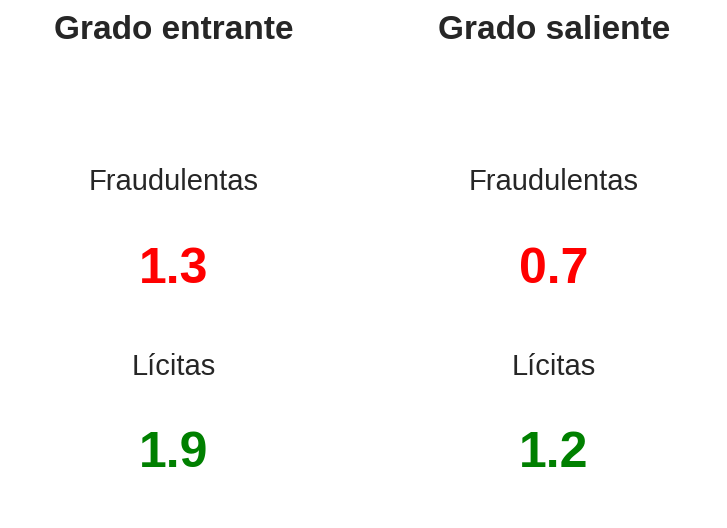

In [222]:
# Extraemos valores
fraud_in = grado_promedio_por_etiqueta.loc['1', 'in_degree']
licit_in = grado_promedio_por_etiqueta.loc['2', 'in_degree']
fraud_out = grado_promedio_por_etiqueta.loc['1', 'out_degree']
licit_out = grado_promedio_por_etiqueta.loc['2', 'out_degree']


fig, axs = plt.subplots(1, 2, figsize=(6, 4), gridspec_kw={'wspace': 0.2})

# Grado Entrante
axs[0].axis('off')
axs[0].set_title('Grado entrante', fontsize=16, fontweight='bold')
axs[0].text(0.5, 0.7, 'Fraudulentas', ha='center', fontsize=14)
axs[0].text(0.5, 0.5, f"{fraud_in:.1f}", ha='center', fontsize=24, fontweight='bold', color='red')
axs[0].text(0.5, 0.3, 'Lícitas', ha='center', fontsize=14)
axs[0].text(0.5, 0.1, f"{licit_in:.1f}", ha='center', fontsize=24, fontweight='bold', color='green')

# Grado Saliente
axs[1].axis('off')
axs[1].set_title('Grado saliente', fontsize=16, fontweight='bold')
axs[1].text(0.5, 0.7, 'Fraudulentas', ha='center', fontsize=14)
axs[1].text(0.5, 0.5, f"{fraud_out:.1f}", ha='center', fontsize=24, fontweight='bold', color='red')
axs[1].text(0.5, 0.3, 'Lícitas', ha='center', fontsize=14)
axs[1].text(0.5, 0.1, f"{licit_out:.1f}", ha='center', fontsize=24, fontweight='bold', color='green')

plt.tight_layout()
plt.savefig("./figures/degrees-by-label.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()


## Dimensionalidad y correlación

In [223]:
corr_matrix = df_features.corr().abs()


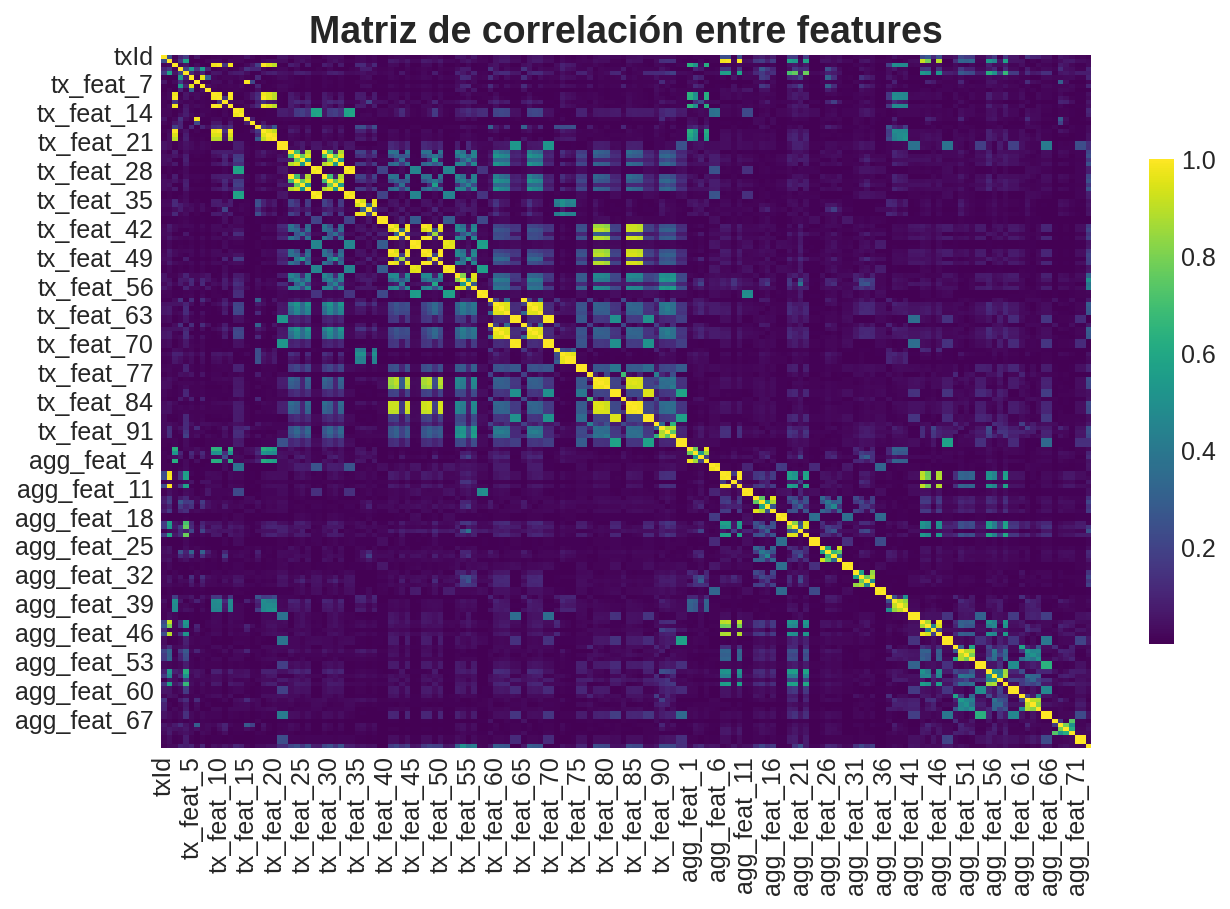

In [224]:
sns.heatmap(corr_matrix, cmap='viridis', vmax=1.0, cbar_kws={'shrink': 0.7})
plt.title("Matriz de correlación entre features")
plt.show()

In [225]:
# Eliminar la diagonal (autocorrelación)
np.fill_diagonal(corr_matrix.values, 0)

# "Desenrollar" la matriz para obtener pares (feature1, feature2, correlación)
corr_pairs = (
    corr_matrix
    .stack()  # convierte matriz a Series con MultiIndex
    .reset_index()  # pasar MultiIndex a columnas
    .rename(columns={0: 'correlation', 'level_0': 'feature_1', 'level_1': 'feature_2'})
)

# Ordenar por correlación descendente
corr_pairs_sorted = corr_pairs.sort_values(by='correlation', ascending=False)

# Opcional: filtrar por un umbral, por ejemplo > 0.8
corr_pairs_filtered = corr_pairs_sorted[corr_pairs_sorted['correlation'] > 0.8]

corr_pairs_filtered  # las 10 parejas más correlacionadas (excepto 1.0)

,feature_1,feature_2,correlation
4231,tx_feat_25,tx_feat_31,1.000000
5233,tx_feat_31,tx_feat_25,1.000000
5064,tx_feat_30,tx_feat_24,1.000000
4062,tx_feat_24,tx_feat_30,1.000000
4400,tx_feat_26,tx_feat_32,1.000000
...,...,...,...
26701,agg_feat_64,agg_feat_63,0.824561
19098,agg_feat_19,agg_feat_20,0.820182
19265,agg_feat_20,agg_feat_19,0.820182
8958,tx_feat_53,tx_feat_54,0.813487


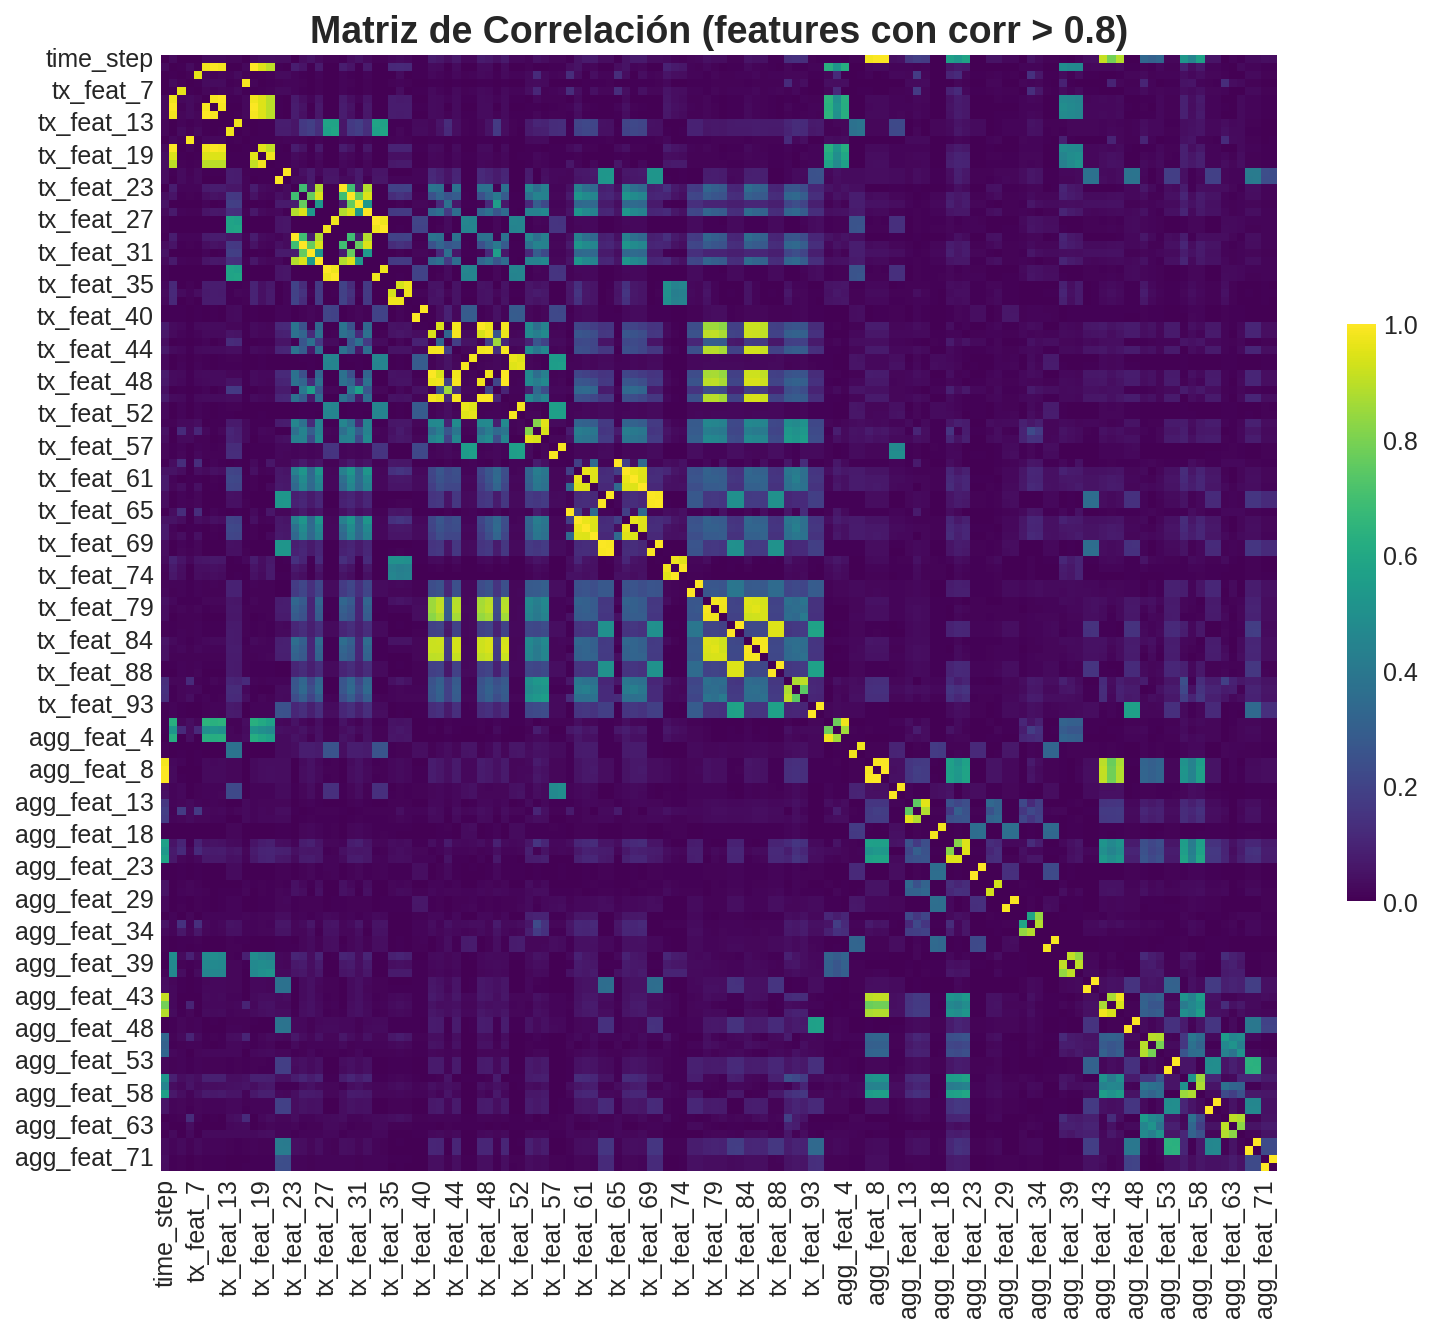

In [226]:
# Matriz de correlación absoluta
corr_matrix = df_features.corr().abs()

# Eliminar diagonal para que no afecte el filtro
np.fill_diagonal(corr_matrix.values, 0)

# Seleccionar features que tienen al menos una correlación > 0.5
features_filtradas = corr_matrix.columns[(corr_matrix > 0.8).any()]

# Subconjunto de la matriz solo con esas features
corr_submatrix = corr_matrix.loc[features_filtradas, features_filtradas]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_submatrix,
    cmap='viridis',
    vmax=1.0,
    vmin=0,
    square=True,
    cbar_kws={'shrink': 0.5}
)
plt.title('Matriz de Correlación (features con corr > 0.8)')
plt.savefig("./figures/corr-matrix-08.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()

### PCA

In [227]:
# creamos series para modelado
X = df_features[['time_step'] + tx_features+agg_features]
y = df_features['label'].astype(int)

# escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [228]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_pca = df_features

df_pca['pca_1'] = X_pca[:, 0]
df_pca['pca_2'] = X_pca[:, 1]

In [229]:
# Colores para cada etiqueta
paleta = {
    'Fraudulenta': 'red',
    'Licita': 'green',
    'Desconocida': 'gray'
}

# Crear un subplot por etiqueta
etiquetas = df_pca['fraud_label_str'].unique()
fig, axes = plt.subplots(1, len(etiquetas), figsize=(6 * len(etiquetas), 5), sharex=True, sharey=True)

for ax, etiqueta in zip(axes, etiquetas):
    subset = df_pca[df_pca['fraud_label_str'] == etiqueta]
    ax.scatter(
        subset['pca_1'], subset['pca_2'],
        color=paleta[etiqueta],
        alpha=0.5,
        s=20
    )
    ax.set_title(f"{etiqueta}")
    ax.set_xlabel("Componente principal 1")
    ax.set_ylabel("Componente principal 2")
    ax.grid(True)

plt.suptitle("Distribución en 2 componentes principales", fontsize=14)
plt.tight_layout()
plt.savefig("./figures/pca-by-label.png", 
    dpi=300, 
    bbox_inches='tight', 
    transparent=True)
plt.show()


KeyError: 'fraud_label_str'

In [ ]:
# Proporción explicada por cada componente
var_exp = pca.explained_variance_ratio_
print("Proporción explicada por cada componente:", var_exp)

# Proporción total explicada por las dos componentes
var_exp_total = var_exp.sum()
print(f"Variabilidad explicada total: {var_exp_total:.2%}")

Proporción explicada por cada componente: [0.10422592 0.0646579 ]
Variabilidad explicada total: 16.89%
